In [ ]:
import sys
import shutil
import os
import numpy as np
import matplotlib.pyplot as plt
import flopy

In [ ]:
# Analytical solutions needed for comparison
import analytical

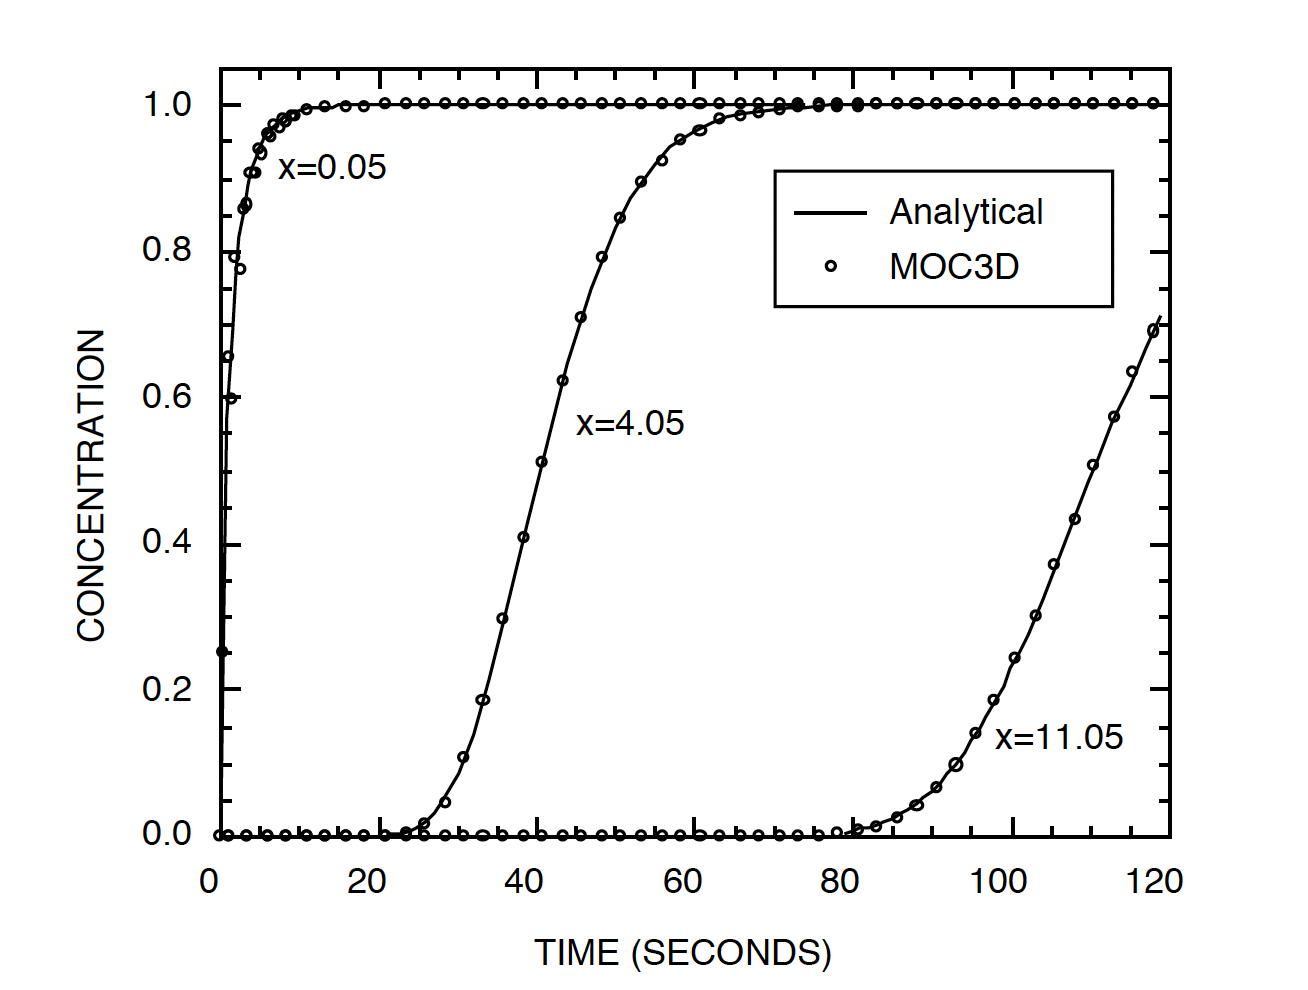

### Model parameters

$Tx = Ty = 0.01 cm^2/s$

$\theta = 0.1$

$\alpha_L = 0.1 cm$

$\alpha_T$ = $\alpha_V$ = 0.1

PERLEN = 120. sec

$V_x$ = 0.1 cm/sec

$V_y = V_z$ = 0.0 cm/sec

Initial concentration $C_0$ = 0.

Source concentration $C^{\prime}$ = 1.

NLAY, NROW, NCOL = 1, 122, 1

DELR = DELC = 0.1 cm

Thickness ($b$) = 1.0 cm





### Set model executable, work space, and model name

In [ ]:
mf6exe = "mf6"
ws = "temp/Wexler1d"
name = "Wexler1d"

### Model discretization

In [ ]:
nper, perlen, nstep, tsmult, steady = 1, 120., 240., 1., True

In [ ]:
nlay, nrow, ncol = 1, 122, 1
delr, delc = 1., 0.1
length = nrow * delc
top = 1.
botm = 0.

### Hydraulic properties

In [ ]:
hk = 0.1
icelltype = 0
velocity = 0.1

### Transport properties

In [ ]:
porosity = 0.01
diffc = 0.
alh = 0.1
alv = alh
d = alh * velocity
advscheme='tvd'

### Initial conditions

In [ ]:
strt = 1.
c0 = 0.
cprime = 1.

### IMS parameters

In [ ]:
nouter, ninner = 100, 300
hclose, rclose, relax = 1e-8, 1e-6, 1.

### Concentration observation locations

In [ ]:
cidx = [(0, 0, 0), (0, 40, 0), (0, 110, 0)]

### Build the groundwater flow model

In [ ]:
# build MODFLOW 6 files
sim = flopy.mf6.MFSimulation(sim_name=name, version='mf6',
                             exe_name=mf6exe,
                             sim_ws=ws)
# create tdis package
tdis = flopy.mf6.ModflowTdis(sim, time_units='DAYS',
                             nper=nper, perioddata=[[perlen, nstep, tsmult]])

# create gwf model
gwfname = 'gwf_' + name
gwf = flopy.mf6.MFModel(sim, model_type='gwf6', modelname=gwfname)

# create iterative model solution and register the gwf model with it
imsgwf = flopy.mf6.ModflowIms(sim, print_option='SUMMARY',
                              outer_dvclose=hclose,
                              outer_maximum=nouter,
                              under_relaxation='NONE',
                              inner_maximum=ninner,
                              inner_dvclose=hclose, rcloserecord=rclose,
                              linear_acceleration='CG',
                              scaling_method='NONE',
                              reordering_method='NONE',
                              relaxation_factor=relax,
                              filename='{}.ims'.format(gwfname))
sim.register_ims_package(imsgwf, [gwf.name])

dis = flopy.mf6.ModflowGwfdis(gwf, nlay=nlay, nrow=nrow, ncol=ncol,
                              delr=delr, delc=delc,
                              top=top, botm=botm,
                              idomain=np.ones((nlay, nrow, ncol), dtype=np.int))

# initial conditions
ic = flopy.mf6.ModflowGwfic(gwf, strt=strt)

# node property flow
npf = flopy.mf6.ModflowGwfnpf(gwf, save_flows=False,
                              save_specific_discharge=True,
                              icelltype=icelltype,
                              k=hk)

# chd files
c = {0: [[(0, nrow - 1, 0), 0.0000000]]}
chd = flopy.mf6.ModflowGwfchd(gwf,
                              stress_period_data=c,
                              save_flows=False,
                              pname='CHD-1')

# wel files
q = 0.001
w = {0: [[(0, 0, 0), q, cprime]]}
wel = flopy.mf6.ModflowGwfwel(gwf,
                              print_input=True,
                              print_flows=True,
                              stress_period_data=w,
                              save_flows=False,
                              auxiliary='CONCENTRATION',
                              pname='WEL-1')

# output control
oc = flopy.mf6.ModflowGwfoc(gwf,
                            budget_filerecord='{}.cbc'.format(gwfname),
                            head_filerecord='{}.hds'.format(gwfname),
                            headprintrecord=[
                                ('COLUMNS', 10, 'WIDTH', 15,
                                 'DIGITS', 6, 'GENERAL')],
                            saverecord=[('HEAD', 'LAST')],
                            printrecord=[('HEAD', 'LAST'),
                                         ('BUDGET', 'LAST')])


### Build the transport model

In [ ]:
# create gwt model
gwtname = 'gwt_' + name
gwt = flopy.mf6.MFModel(sim, model_type='gwt6', modelname=gwtname)

# create iterative model solution and register the gwt model with it
imsgwt = flopy.mf6.ModflowIms(sim, print_option='SUMMARY',
                              outer_dvclose=hclose,
                              outer_maximum=nouter,
                              under_relaxation='NONE',
                              inner_maximum=ninner,
                              inner_dvclose=hclose, rcloserecord=rclose,
                              linear_acceleration='BICGSTAB',
                              scaling_method='NONE',
                              reordering_method='NONE',
                              relaxation_factor=relax,
                              filename='{}.ims'.format(gwtname))
sim.register_ims_package(imsgwt, [gwt.name])

dis = flopy.mf6.ModflowGwtdis(gwt, nlay=nlay, nrow=nrow, ncol=ncol,
                              delr=delr, delc=delc,
                              top=top, botm=botm,
                              idomain=1)

# initial conditions
strt = np.zeros((nlay, nrow, ncol))
strt[0, 0, 0] = 0.
ic = flopy.mf6.ModflowGwtic(gwt, strt=strt)

# advection
adv = flopy.mf6.ModflowGwtadv(gwt, scheme=advscheme)

# dispersion
dsp = flopy.mf6.ModflowGwtdsp(gwt, diffc=diffc,
                              alh=alh, alv=alv,
                              ath1=0.0, atv=0.0)

porosity = 0.01
mst = flopy.mf6.ModflowGwtmst(gwt, porosity=porosity)

# sources
sourcerecarray = [('WEL-1', 'AUX', 'CONCENTRATION')]
ssm = flopy.mf6.ModflowGwtssm(gwt, sources=sourcerecarray)

# output control
oc = flopy.mf6.ModflowGwtoc(gwt,
                            budget_filerecord='{}.cbc'.format(gwtname),
                            concentration_filerecord='{}.ucn'.format(gwtname),
                            concentrationprintrecord=[
                                ('COLUMNS', 10, 'WIDTH', 15,
                                 'DIGITS', 6, 'GENERAL')],
                            saverecord=[('CONCENTRATION', 'ALL')],
                            printrecord=[('CONCENTRATION', 'LAST'),
                                         ('BUDGET', 'LAST')]
                           )

# GWF GWT exchange
gwfgwt = flopy.mf6.ModflowGwfgwt(sim, exgtype='GWF6-GWT6',
                                 exgmnamea=gwfname, exgmnameb=gwtname,
                                 filename='{}.gwfgwt'.format(name))

### Write the simulation and run the models

In [ ]:
sim.write_simulation()
sim.run_simulation()

### Post process the results

In [ ]:
cts = gwt.output.concentration().get_ts(cidx)

### Calculate the analytical solution

In [ ]:
times = np.arange(0, 120, .1)
x = np.linspace(0, length, nrow)
wex = []
for i, x in enumerate([0.05, 4.05, 11.05]):
    wex.append(analytical.Wexler1d().analytical(x, times, velocity, length, d))

### Plot the results

In [ ]:
alabel = ['ANALYTICAL', '', '']
mlabel = ['MODFLOW 6', '', '']
iskip = 5

In [ ]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1, 1, 1)
for i, a1 in enumerate(wex):
    idx = a1 < 0
    a1[idx] = 0
    idx = a1 > 1
    a1[idx] = 0
    idx = times > 0
    if i == 2:
        idx = times > 79
    ax.plot(times[idx], a1[idx], color='k', label=alabel[i])
    ax.plot(cts[::iskip, 0], cts[::iskip, i+1], marker='o', ls='none',
             mec='blue', mfc='none', label=mlabel[i])
ax.set_ylim(0, 1.2)
ax.set_xlim(0, 120)
ax.set_xlabel('TIME, IN SECONDS')
ax.set_ylabel('NORMALIZED CONCENTRATION')
ax.legend()
ax.text(1, .5, 'x=0.05')
ax.text(45, .5, 'x=4.05')
ax.text(100, .5, 'x=11.05');